# Single Stock Analysis

The notebook here allows to perform analysis for a single exchange security.

In [13]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# Data downloading

In [14]:
start = '2012-01-01'
end = '2017-12-31'
stock_symbol = 'MAB'

# Uncomment line below to download latest quotes for stocks
#%run ../money_machine_app/downloaders/stocks_data_downloader.py $start $end $stock_symbol


# Data preprocessing

In [15]:
# The CSV file has following columns: 
# Data, Otwarcie, Najwyzszy, Najnizszy, Zamkniecie, Wolumen
stock = pd.read_csv(f'./data-archive/stocks/{stock_symbol}.csv',
                   delimiter=',',
                   index_col='Data',
                   parse_dates=True)

In [16]:
# drop unnecessary columns
stock.drop(['Otwarcie', 'Najwyzszy', 'Najnizszy'], axis=1, inplace=True)

# rename column and index
stock.columns = ['Close', 'Volume']
stock.index.names = ['Date']

In [17]:
stock.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1439 entries, 2012-01-02 to 2017-10-19
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1439 non-null   float64
 1   Volume  1439 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 33.7 KB


# Analysis

## Normalize Price

This is same as cumulative daily returns.

In [18]:
stock['Normed Return'] = stock['Close'] / stock.iloc[0]['Close']

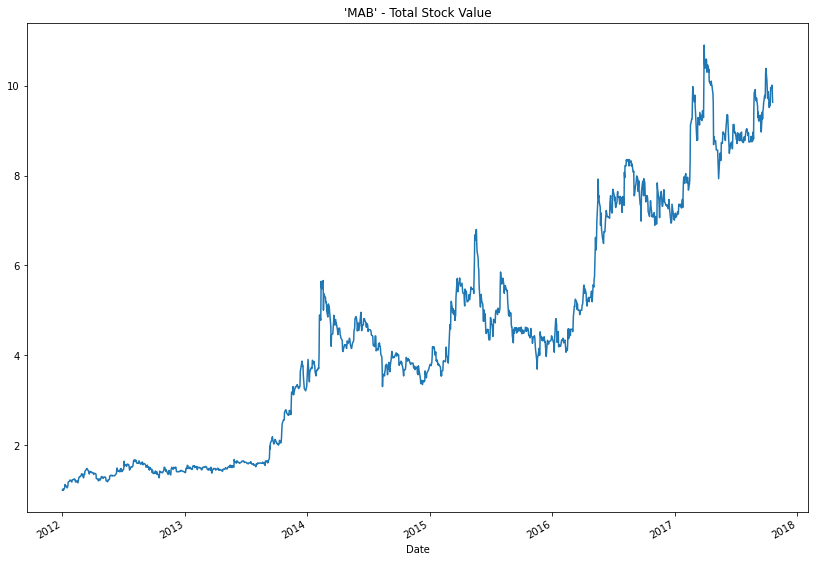

In [19]:
stock['Normed Return'].plot(figsize=(14,10))
plt.title(f"'{stock_symbol}' - Total Stock Value");

# Statistics

In [20]:
stock['Daily Return'] = stock['Close'].pct_change(1)

In [21]:
stock.tail()

,Close,Volume,Normed Return,Daily Return
Date,,,,
2017-10-13,105.50,4834,9.962229,0.032795
2017-10-16,105.35,1596,9.948064,-0.001422
2017-10-17,106.05,1325,10.014164,0.006645
2017-10-18,104.50,4064,9.867800,-0.014616
2017-10-19,102.00,11340,9.631728,-0.023923


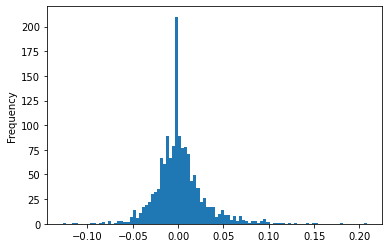

In [23]:
stock['Daily Return'].plot(kind='hist', bins=100);

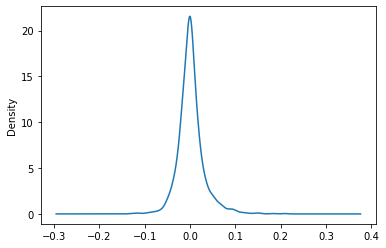

In [24]:
stock['Daily Return'].plot(kind='kde');

# Average Daily Return


In [25]:
stock['Daily Return'].mean()

0.0019833095425608287

Std Daily Return

In [26]:
stock['Daily Return'].std()

0.02882976725840105

In [27]:
SR = stock['Daily Return'].mean() / stock['Daily Return'].std()

if SR <= 1:
    print(f'Sharpe Ratio = {SR}. Too risky asset.')
elif SR <= 2:
    print(f'Sharpe Ratio = {SR}. Good.')
elif SR <= 3:
    print(f'Sharpe Ratio = {SR}. Great.')
else:
    print(f'Sharpe Ratio = {SR}. Excellent.')

Sharpe Ratio = 0.06879381039688721. Too risky asset.


In [28]:
ASR = (252**0.5) * SR
print(f'Annual Sharpe Ratio = {ASR}')

Annual Sharpe Ratio = 1.0920678843041594


# Moving Average

SMA

In [29]:
sma_1 = 10
sma_2 = 30

stock[f'SMA {sma_1}'] = stock['Close'].rolling(window=sma_1).mean()
stock[f'SMA {sma_2}'] = stock['Close'].rolling(window=sma_2).mean()

# crossovers
stock['signal'] = 0.0
stock['signal'][sma_1:] = np.where(stock[f'SMA {sma_1}'][sma_1:] > stock[f'SMA {sma_2}'][sma_1:], 1.0, 0.0)
stock['positions'] = stock['signal'].diff()

<ipython-input-29-b73196c09cbc>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock['signal'][sma_1:] = np.where(stock[f'SMA {sma_1}'][sma_1:] > stock[f'SMA {sma_2}'][sma_1:], 1.0, 0.0)


No handles with labels found to put in legend.


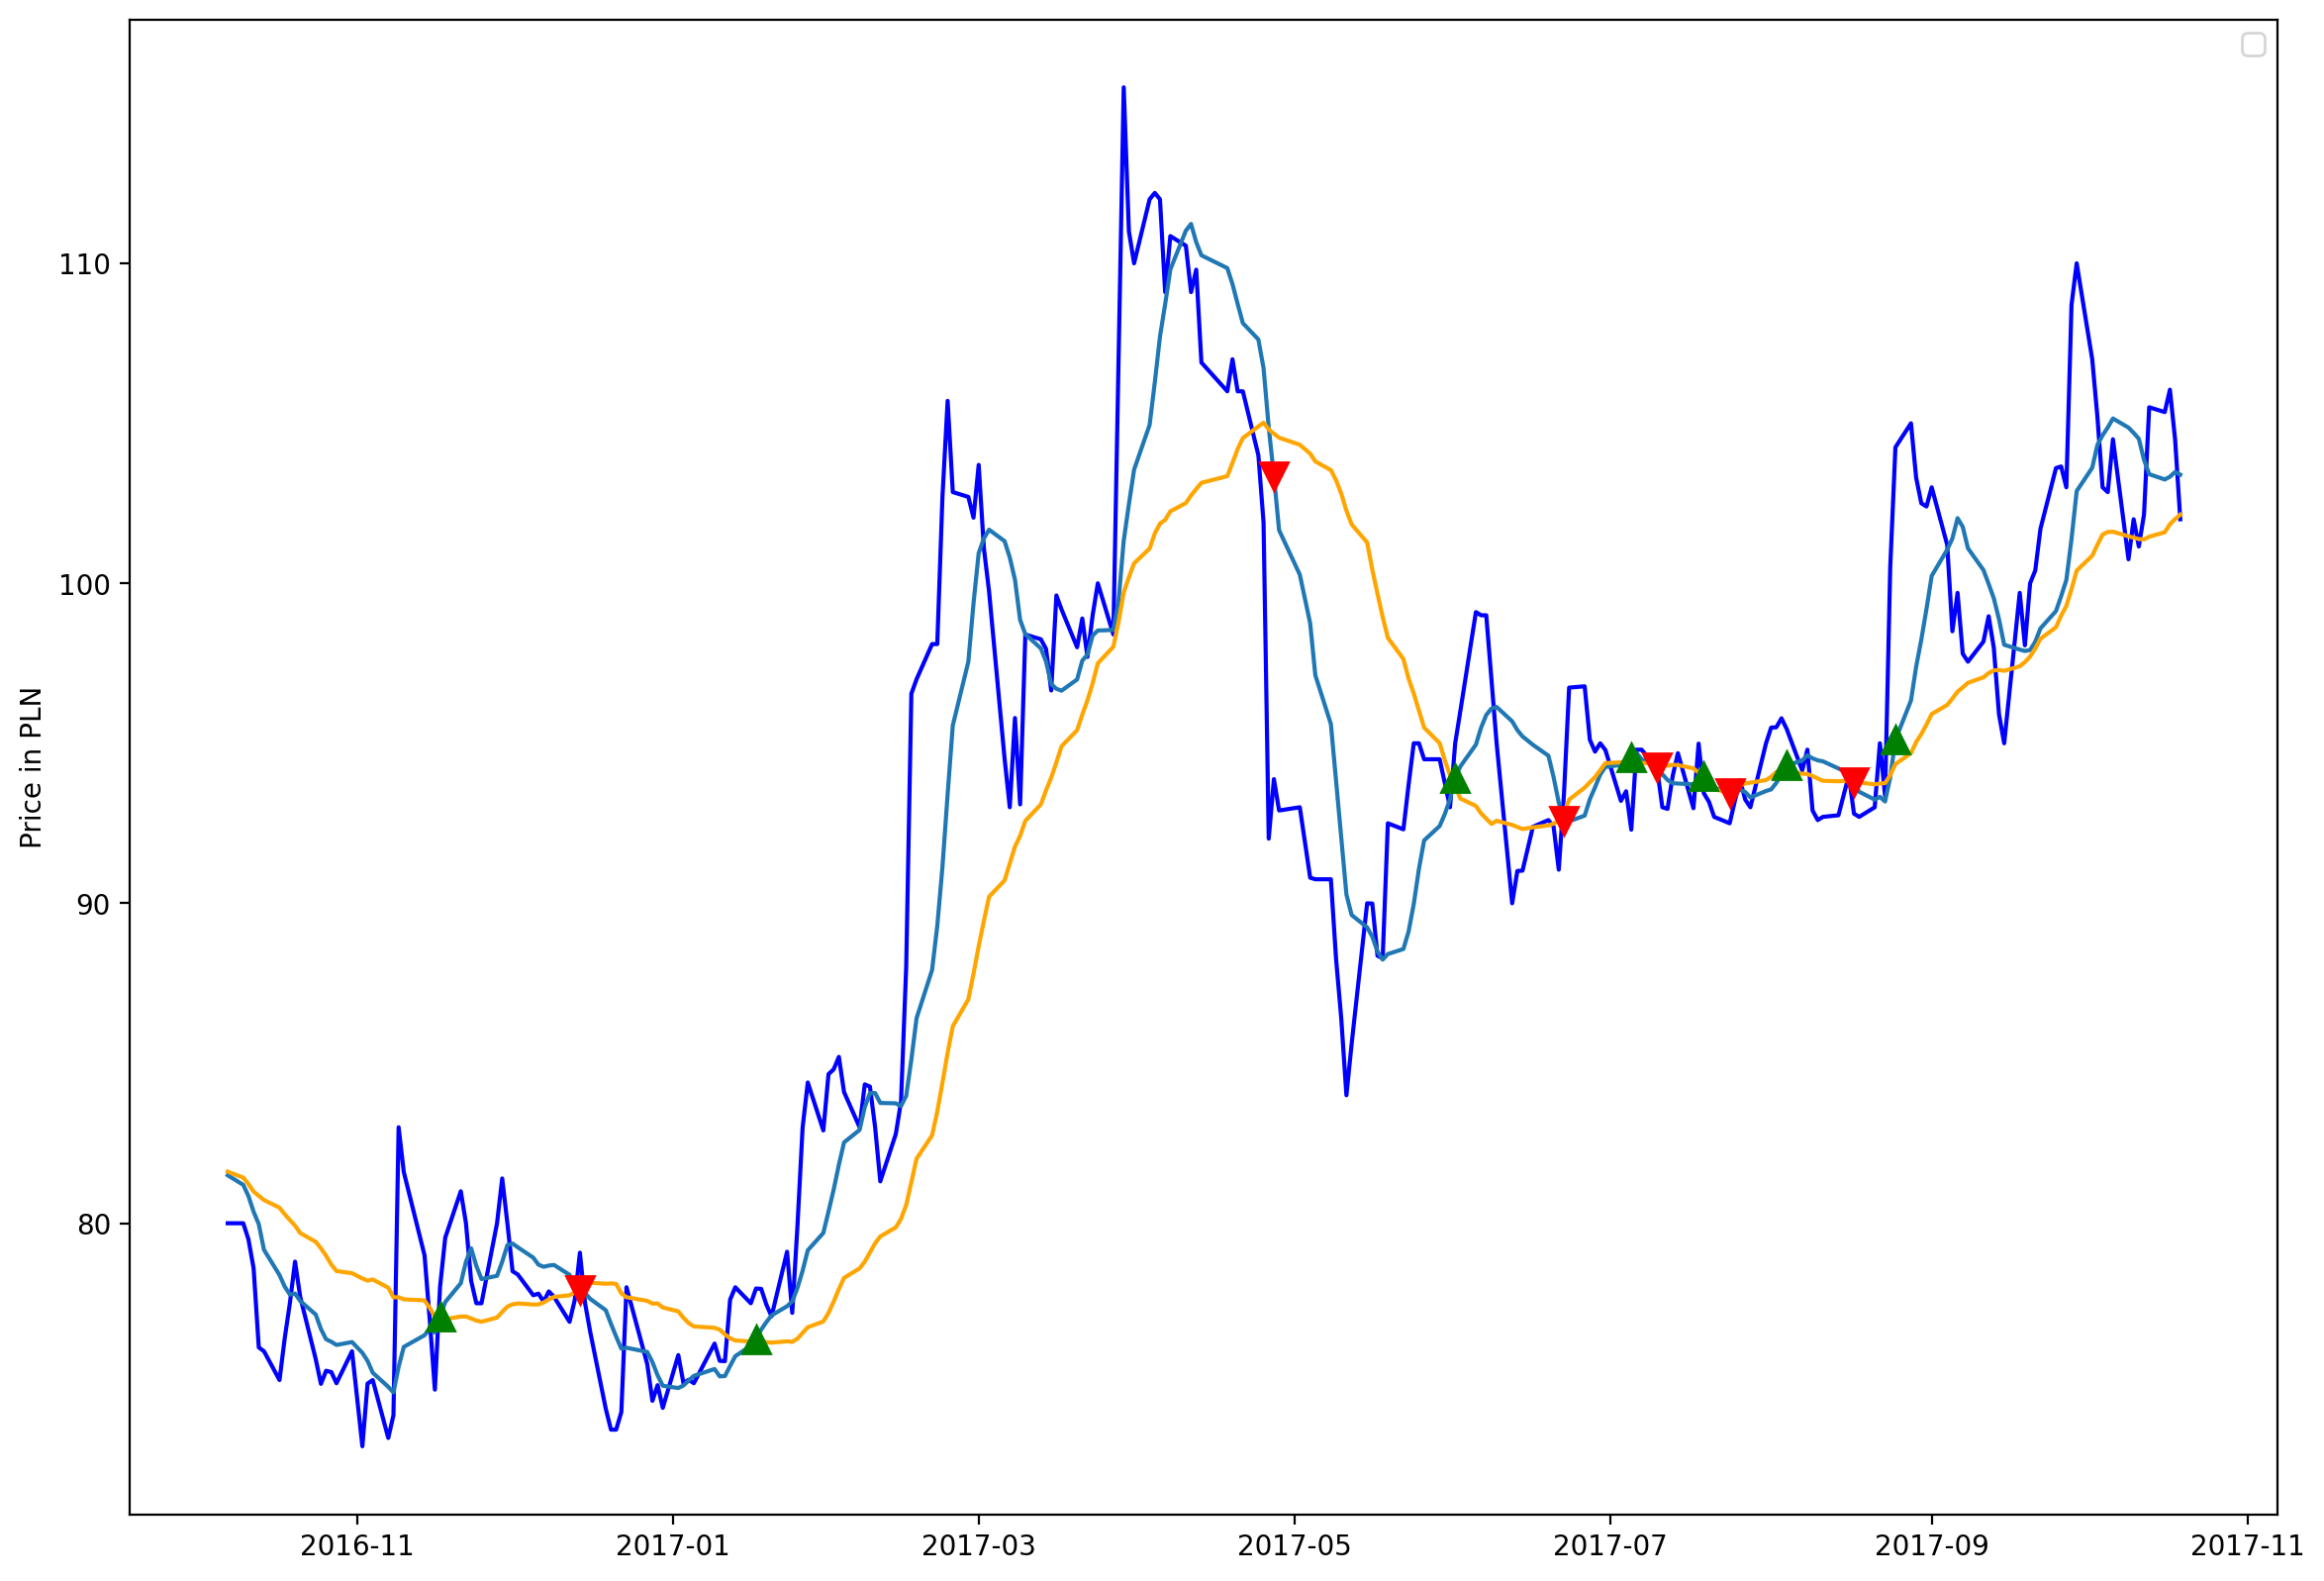

In [30]:
recent_stock = stock.tail(260);

fig = plt.figure(figsize=(14,10), dpi=200);
fig.patch.set_facecolor('white');     # Set the outer colour to white
ax1 = fig.add_subplot(111, ylabel='Price in PLN');

#stock['Close'].tail(260).plot(ax=ax1, color='r');
#stock[[f'SMA {sma_1}', f'SMA {sma_2}']].tail(260).plot(ax=ax1);

ax1.plot(recent_stock['Close'], color='blue')
ax1.plot(recent_stock[f'SMA {sma_1}'])
ax1.plot(recent_stock[f'SMA {sma_2}'], color='orange')

# Plot the "buy" trades
ax1.plot(recent_stock[recent_stock["positions"] == 1.0].index, 
         recent_stock[f'SMA {sma_1}'][recent_stock["positions"] == 1.0],
         '^', markersize=10, color='g');

# Plot the "sell" trades
ax1.plot(recent_stock[recent_stock["positions"] == -1.0].index, 
         recent_stock[f'SMA {sma_1}'][recent_stock['positions'] == -1.0],
         'v', markersize=10, color='r');

ax1.legend();

Suggested 'Buy' dates

In [32]:
recent_stock[recent_stock["positions"] == 1.0].index.tolist()

[Timestamp('2016-11-17 00:00:00'),
 Timestamp('2017-01-17 00:00:00'),
 Timestamp('2017-06-01 00:00:00'),
 Timestamp('2017-07-05 00:00:00'),
 Timestamp('2017-07-19 00:00:00'),
 Timestamp('2017-08-04 00:00:00'),
 Timestamp('2017-08-25 00:00:00')]

Suggested 'Sell' dates

In [33]:
recent_stock[recent_stock["positions"] == -1.0].index.tolist()

[Timestamp('2016-12-14 00:00:00'),
 Timestamp('2017-04-27 00:00:00'),
 Timestamp('2017-06-22 00:00:00'),
 Timestamp('2017-07-10 00:00:00'),
 Timestamp('2017-07-24 00:00:00'),
 Timestamp('2017-08-17 00:00:00')]

Bollinger Bands

In [35]:
stock['SMA 20'] = stock['Close'].rolling(window=20).mean()
stock['B-Band Upper'] = stock['SMA 20'] + 2*stock['Close'].rolling(window=20).std()
stock['B-Band Lower'] = stock['SMA 20'] - 2*stock['Close'].rolling(window=20).std()

In [36]:
stock['BB-signal'] = 0.0
stock['BB-signal'][20:] = np.where(stock['Close'][20:] >= stock['B-Band Upper'][20:], 1.0, 0.0)
stock['BB-sell-positions'] = stock['BB-signal'].diff()

stock['BB-signal'] = 0.0
stock['BB-signal'][20:] = np.where(stock['Close'][20:] <= stock['B-Band Lower'][20:], -1.0, 0.0)
stock['BB-buy-positions'] = stock['BB-signal'].diff()

recent_stock = stock.tail(260)

<ipython-input-36-312e7430d58e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock['BB-signal'][20:] = np.where(stock['Close'][20:] >= stock['B-Band Upper'][20:], 1.0, 0.0)
<ipython-input-36-312e7430d58e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock['BB-signal'][20:] = np.where(stock['Close'][20:] <= stock['B-Band Lower'][20:], -1.0, 0.0)


No handles with labels found to put in legend.


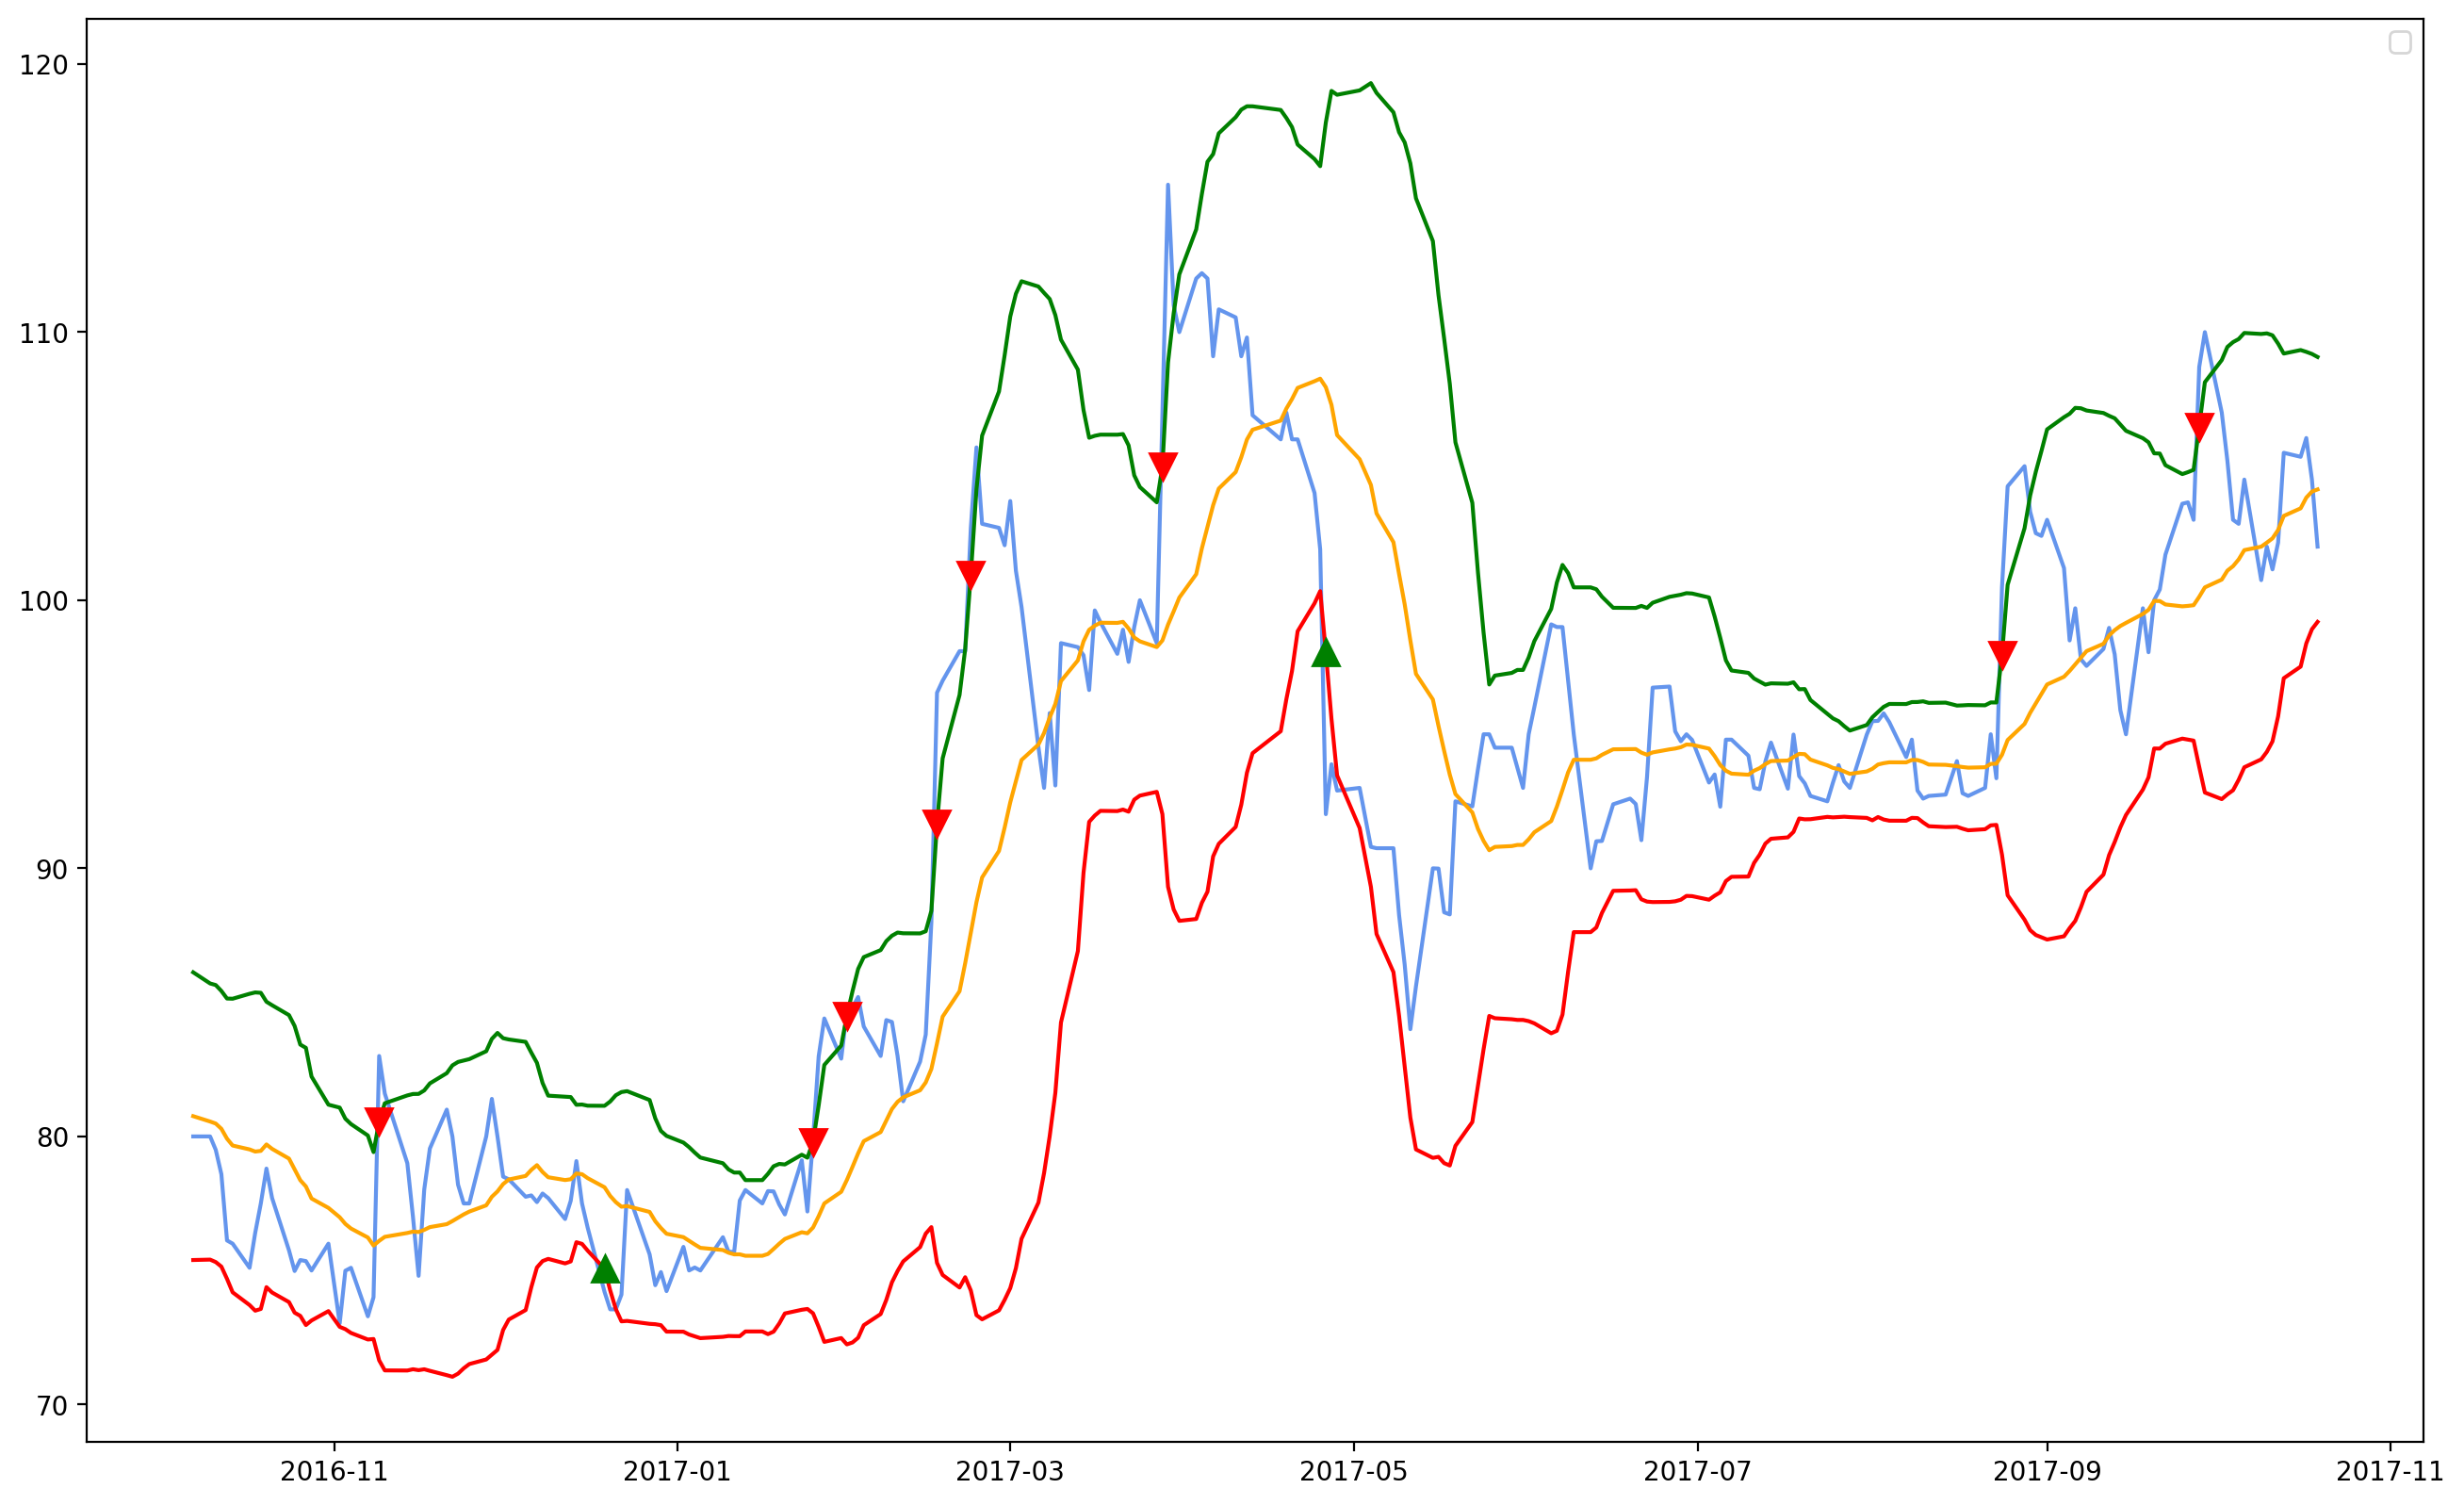

In [37]:
fig,ax1 = plt.subplots(figsize=(16,10), dpi=200);

ax1.plot(recent_stock['Close'], color='cornflowerblue')
ax1.plot(recent_stock['SMA 20'], color='orange')
ax1.plot(recent_stock['B-Band Upper'], color='green')
ax1.plot(recent_stock['B-Band Lower'], color='red')

# Plot the "sell" trades
ax1.plot(recent_stock[recent_stock["BB-sell-positions"] == 1.0].index, 
         recent_stock['B-Band Upper'][recent_stock["BB-sell-positions"] == 1.0],
         'v', markersize=10, color='r');

# Plot the "buy" trades
ax1.plot(recent_stock[recent_stock["BB-buy-positions"] == -1.0].index, 
         recent_stock['B-Band Lower'][recent_stock["BB-buy-positions"] == -1.0],
         '^', markersize=10, color='g');

ax1.legend();

Suggested 'Buy' dates

In [38]:
recent_stock[recent_stock["BB-buy-positions"] == -1.0].index.tolist()

[Timestamp('2016-12-19 00:00:00'), Timestamp('2017-04-26 00:00:00')]

Suggested 'Sell' dates

In [39]:
recent_stock[recent_stock["BB-sell-positions"] == 1.0].index.tolist()

[Timestamp('2016-11-09 00:00:00'),
 Timestamp('2017-01-25 00:00:00'),
 Timestamp('2017-01-31 00:00:00'),
 Timestamp('2017-02-16 00:00:00'),
 Timestamp('2017-02-22 00:00:00'),
 Timestamp('2017-03-28 00:00:00'),
 Timestamp('2017-08-24 00:00:00'),
 Timestamp('2017-09-28 00:00:00')]

# EWMA

In [40]:
stock[f'EWMA {sma_1}'] = stock['Close'].ewm(span=10).mean()
stock[f'EWMA {sma_2}'] = stock['Close'].ewm(span=20).mean()

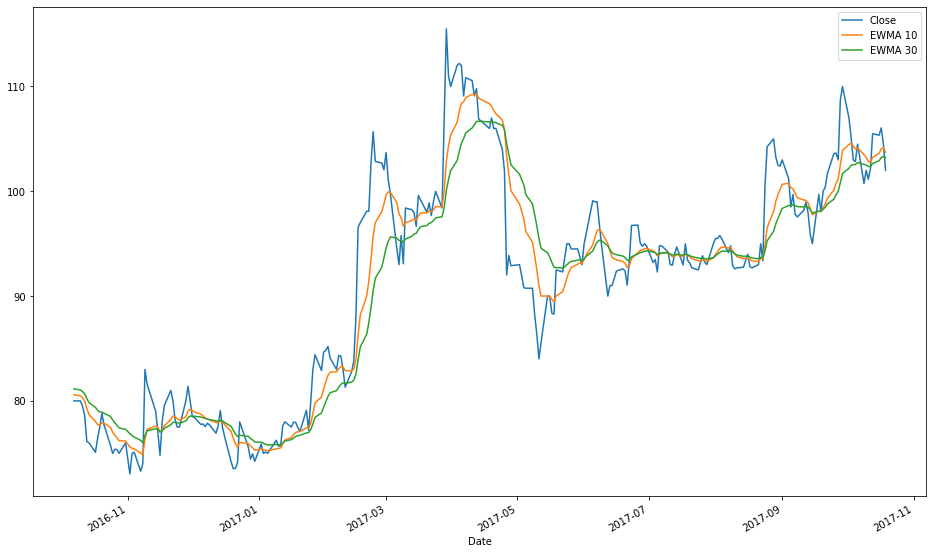

In [41]:
stock[['Close', f'EWMA {sma_1}', f'EWMA {sma_2}']].tail(260).plot(figsize=(16,10));

# ARIMA

In [42]:
from statsmodels.tsa.stattools import adfuller

def adf_check(time_series):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    print("")
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary.")
    else:
        print("Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary.")

In [43]:
adf_check(stock['SMA 20'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -0.43450510345846627
p-value : 0.9041763039060673
#Lags Used : 21
Number of Observations Used : 1398

Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary.


In [44]:
stock['SMA 20 - First Diff'] = stock['SMA 20'] - stock['SMA 20'].shift(1)
adf_check(stock['SMA 20 - First Diff'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -5.107217047250669
p-value : 1.3558036299095265e-05
#Lags Used : 20
Number of Observations Used : 1398

Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary.


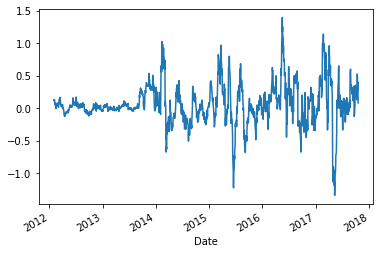

In [46]:
stock['SMA 20 - First Diff'].plot();

<ipython-input-47-91cd3f289ef8>:2: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  decomposition = seasonal_decompose(stock['SMA 20 - First Diff'].dropna().tail(300), freq=12)


<Figure size 432x288 with 0 Axes>

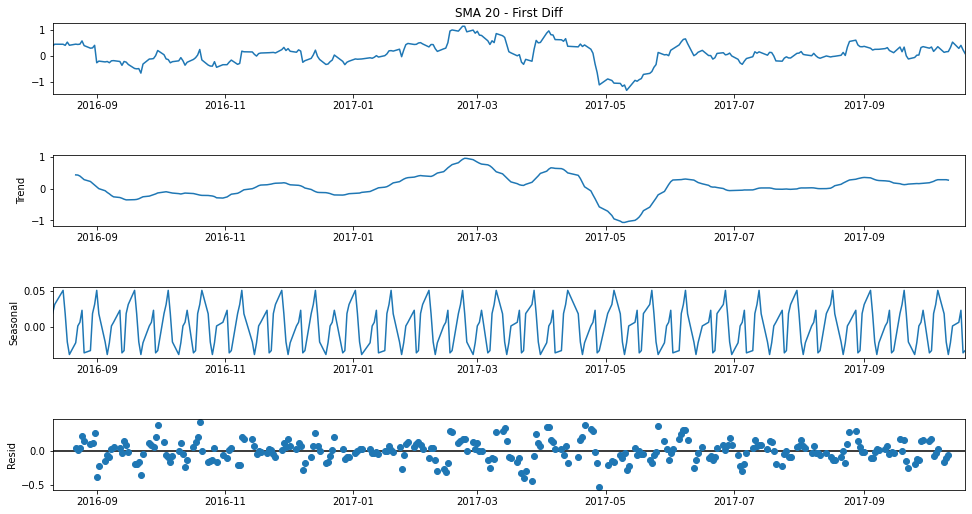

In [47]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(stock['SMA 20 - First Diff'].dropna().tail(300), freq=12)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

In [48]:
import statsmodels.api as sm

model = sm.tsa.statespace.SARIMAX(stock['SMA 20 - First Diff'].dropna().tail(300),order=(0,1,0), seasonal_order=(1,1,1,12))
results = model.fit()
#print(results.summary())

C:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [49]:
#stock['forecast'] = results.predict(start = 1300, end= 1440, dynamic= True)  
#stock[['SMA 20 - First Diff','forecast']].plot(figsize=(12,8))